<a href="https://colab.research.google.com/github/ncsu-geoforall-lab/geomorphometry2025_workshop/blob/main/geomorphometry_2025_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workshop: Propagating DEM Uncertainty to Stream Extraction using GRASS

### Abstract

GRASS is an open-source geospatial processing engine. With over 400 tools available in the core distribution and an additional 400+ tools available as extensions, GRASS has broad applicability in the Earth Sciences and geomorphometry in particular. In this workshop, we will give an introduction to GRASS and demonstrate some of the geomorphometry tools available in GRASS. Specifically, we will show how to compute stream extraction uncertainty using a workflow adapted from Hengl (2007) [1] and Hengl (2010) [2]. In this tutorial, we will:
* [Create a new GRASS project](#start)
* [Download and import elevation data](#data) of near Perugia using GRASS data fetching tools
* [Use R’s kriging functions (gstat)](#R) to create 100 iterations of a DEM
* Use GRASS tools to extract streams from each of the 100 DEMs to compute stream uncertainty

Check out the publication associated with the notebook on Zenodo:

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.15283714.svg)](https://doi.org/10.5281/zenodo.15283714)


---


### Install GRASS and Get Workshop Materials

The following cell installs GRASS from the ubuntugis-unstable ppa. It will take a minute to run.

In [ ]:
!add-apt-repository -y ppa:ubuntugis/ubuntugis-unstable
!apt update
!apt-get install -y grass-core grass-dev

We can check GRASS installed and see what version we have using:

In [ ]:
!grass --version

In [ ]:
!git clone https://github.com/ncsu-geoforall-lab/geomorphometry2025_workshop.git

<a name="start"></a>

---

## Create a New GRASS Project and Start GRASS

First, let's import all the Python libraries we'll need.

In [1]:
import sys
import subprocess
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Image
from ipyleaflet import ImageService, WMSLayer, Marker
from ipyleaflet.projections import projections
import xyzservices

**Importing the GRASS Python API**

We are going to import the GRASS Python API (`grass.script`) and the GRASS Jupyter package (`grass.jupyter`). But first, we'll need to ask `grass` to check it's `--config` to see where the python packages are then add them to the system path before we can import them.

We use `subprocess.check_output` to find the path and `sys.path.append` to add it to the path.

In [2]:
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

Then, we can import the Python API and GRASS Jupyter packages.

In [3]:
import grass.script as gs
import grass.jupyter as gj

**Starting a New Project**

Now, we create a new project called "geomorphometry_workshop". Projects are defined by a Coordinate Reference System (CRS). We can set the CRS from a georeferenced file (such as a Geotiff) or an EPSG string. Here, we use [EPSG 32632](https://epsg.io/32632), CRS WGS 84/UTM zone 32N (EPSG:32632).

In [4]:
gs.create_project("geomorphometry_workshop", epsg="32632")

You should now see a new folder created called "geomorphometry_workshop". This will contain all of the data for our project and is organized by GRASS's native data format. This makes GRASS _fast_, _scalable_, and _avoids projection mismatches_.

We start a GRASS session in our new project.

In [4]:
gj.init("geomorphometry_workshop")

**Introducting the "Computational Region"**

Finally, let's set our computational region using [`g.region`](https://grass.osgeo.org/grass85/manuals/g.region.html). The computational region will determine what data is imported from the cloud so we need to set it before continuing.

Upon creating a project, the computational region is empty.

In [5]:
print(gs.read_command("g.region", flags="p"))

projection: 1 (UTM)
zone:       32
datum:      wgs84
ellipsoid:  wgs84
north:      4779210
south:      4778120
west:       779180
east:       780630
nsres:      10
ewres:      10
rows:       109
cols:       145
cells:      15805



There are lots of ways to set the computional region, from a georeferenced file or existing data layer to relative operations grow which adds cells around the previous region. Here, we set our computational region with coordinates and set the resolution to 10 meters.

In [6]:
aoi_bbox = {
	"north": 4779210,
	"south": 4778120,
	"west": 779180,
	"east": 780630
}

print(
    gs.read_command(
        "g.region", n=aoi_bbox["north"], s=aoi_bbox["south"], e=aoi_bbox["east"], w=aoi_bbox["west"], res=10, flags="p"
    )
)

projection: 1 (UTM)
zone:       32
datum:      wgs84
ellipsoid:  wgs84
north:      4779210
south:      4778120
west:       779180
east:       780630
nsres:      10
ewres:      10
rows:       109
cols:       145
cells:      15805



<a name="data"></a>

---

## Download and Import Data

Right now, our project has no data in it:

In [8]:
gs.read_command("g.list", type="all")

''

We're going to use a DEM from the TINItaly dataset. Let's get an overview of the dataset using a quick WMS visualization.

In [9]:
tinitaly_wms = WMSLayer(
    name="TINItaly_1.1 HSV (WMS)",
    url="http://tinitaly.pi.ingv.it/TINItaly_1_1/wms?service=WMS",
    layers="TINItaly_1.1:tinitaly_hsv",
    format="image/png",
    transparent=True,
    attribution="HSV Elevation Data © 2023 TINItaly 1.1",
)

tinitaly_slope = WMSLayer(
    name="TINItaly_1.1 Slope (WMS)",
    url="http://tinitaly.pi.ingv.it/TINItaly_1_1/wms?service=WMS",
    layers="TINItaly_1.1:tinitaly_slope",
    format="image/png",
    transparent=True,
    attribution="Slope Data © 2023 TINItaly 1.1",
)

nasa_wms = WMSLayer(
    name="NASA SRTM RAMP2 TOPO (WMS)",
    url="https://neo.gsfc.nasa.gov/wms/wms?service=WMS",
    layers="SRTM_RAMP2_TOPO",
    format="image/png",
    transparent=True,
    styles="rgb",
    attribution="SRTM RAMP2 TOPO © 2025 NASA ",
)

perugia = Marker(
    name="Perugia (Marker)",
    location=(43.11203, 12.38914),
    draggable=False,
    title="Perugia",
    alt="Perugia",
    # icon="fa-flag",
)

In [10]:
nasa_basemap = "NASAGIBS BlueMarble"
m = gj.InteractiveMap(height=600, width=800, tiles=nasa_basemap, use_region=True)
m.map.add(tinitaly_wms)
m.map.add(tinitaly_slope)
m.map.add(nasa_wms)
m.map.add(perugia)
m.add_layer_control()
m.map.zoom = 6
m.map.center = (43.11203, 12.38914)
display(m.show())

Map(center=[43.11203, 12.38914], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

Now we can import our DEM. We will use the [r.import](https://grass.osgeo.org/manuals/grass85/r.import.html) command to import a DEM file. The DEM file is a [Cloud Optimized GeoTIFF (COG)](https://cogeo.org/), and we will specify the output name as "dem". *r.import* will automatically reproject the DEM to the project's CRS.

In [11]:
gs.run_command(
    "r.import",
    input="https://storage.googleapis.com/geomorphometry/w47575_s10.cog.tif",
    output="dem",
    title="TINItaly DEM 10m",
    resample="bicubic_f",
    resolution="region",
    extent="region",
    overwrite=True,
)

Let's get some basic information about our DEM. We'll use the [`r.info`](https://grass.osgeo.org/grass85/manuals/r.info.html) and [`r.univar`](https://grass.osgeo.org/grass85/manuals/r.univar.html) tools to get the rasters metadata and univariate statistics respectively.

In [12]:
print(gs.read_command("r.info", map="dem"))

 +----------------------------------------------------------------------------+
 | Map:      dem                            Date: Tue May 27 13:27:49 2025    |
 | Mapset:   PERMANENT                      Login of Creator: ctwhite         |
 | Project:  geomorphometry_workshop                                          |
 | DataBase: /home/ctwhite/Documents/GitHub/ncsu-geoforall-lab/geomorphometry |
 | Title:                                                                     |
 | Timestamp: none                                                            |
 |----------------------------------------------------------------------------|
 |                                                                            |
 |   Type of Map:  raster               Number of Categories: 0               |
 |   Data Type:    FCELL                Semantic label: (none)                |
 |   Rows:         109                                                        |
 |   Columns:      145                  

**Try it yourself!**

Using the cell above as a template, compute the univariate statistics using [`r.univar`](https://grass.osgeo.org/grass85/manuals/r.univar.html).

<details>
    <summary>👉 <b>click to see hint</b></summary>
  
Run `!r.univar --help` to see the paramters.
</details>


<details>
    <summary>👉 <b>click to see solution</b></summary>
    
```python
print(gs.read_command("r.univar", map="dem", flags="e"))
```
</details>


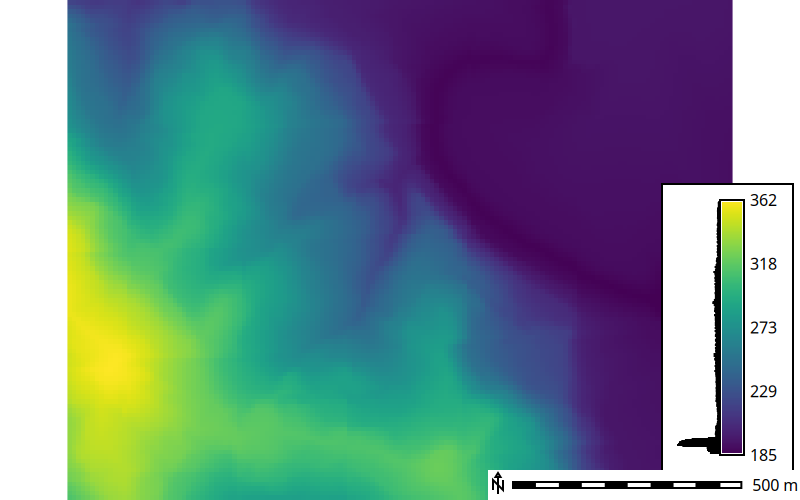

In [13]:
m = gj.Map(use_region=True, height=500, width=800)
m.d_rast(map="dem")
m.d_legend(raster="dem", flags="bds", at="9,60,90,93", fontsize=16)
m.d_barscale(at="61,6", fontsize=16, flags="n")
m.show()

Compute some other common DEM derivatives: shaded relief, slope and aspect.

In [14]:
gs.run_command("r.relief", input="dem", output="relief", scale=1, zscale=1)

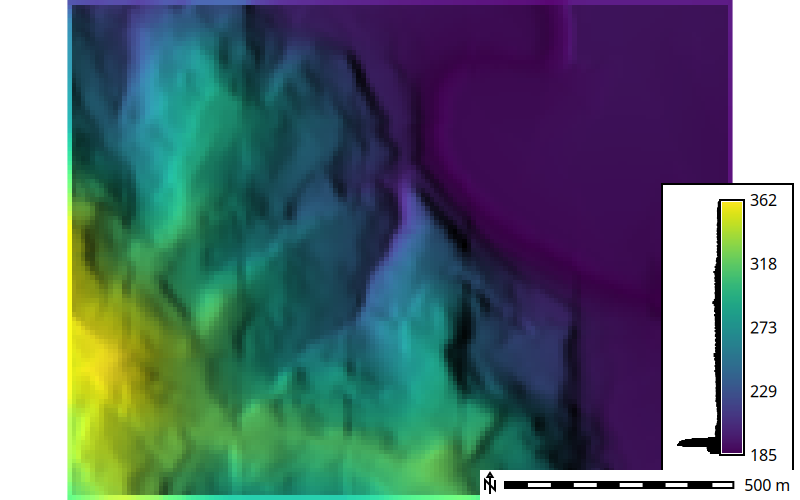

In [15]:
m = gj.Map(use_region=True, height=500, width=800)
m.d_shade(shade="relief", color="dem", brighten=30)
m.d_legend(raster="dem", flags="bds", at="9,60,90,93", fontsize=16)
m.d_barscale(at="60,6", fontsize=16, flags="n")
m.show()


**Try it yourself!**

Compute and display the slope and aspect using [`r.slope.aspect`](https://grass.osgeo.org/grass85/manuals/r.slope.aspect.html). Try changing the color map for the slope raster using [`r.colors`](https://grass.osgeo.org/grass85/manuals/r.colors.html). _Bonus Challenge_: Can you add a legend to your visualization with a histogram showing the range of slope values?

<details>
    <summary>👉 <b>click to see hint</b></summary>
  
Looking at the manual for r.slope.aspect, your code should be formatted like:

```python
gs.run_command("r.slope.aspect", elevation=.., slope=.., aspect=..)
```

To get the legend and histogram, look at the flag options in `d.legend`. Remember that `d.legend` can be called by `grass.jupyter.Map()` with `m.d_legend()`. See above for examples.

</details>


<details>
    <summary>👉 <b>click to see solution</b></summary>
    
```python
gs.run_command("r.slope.aspect", elevation="dem", slope="slope", aspect="aspect")

gs.run_command("r.colors", map="slope", color="sepia", flags="e")

m = gj.Map(use_region=True)
m.d_rast(map="slope")
m.d_legend(raster="slope", flags="bds")
m.show()
```

And for aspect:

```python
m = gj.Map(use_region=True)
m.d_rast(map="aspect")
m.d_legend(raster="aspect", flags="bds")
m.show()
```
</details>


Since we're going to interpolate surfaces from points, we'll randomly sample points from the DEM. We could think of these as LiDAR points or ground sampled points.

In [7]:
gs.run_command("r.random", input="dem", vector="elevrand", n=500, flags="s")

Now, visualize the points.

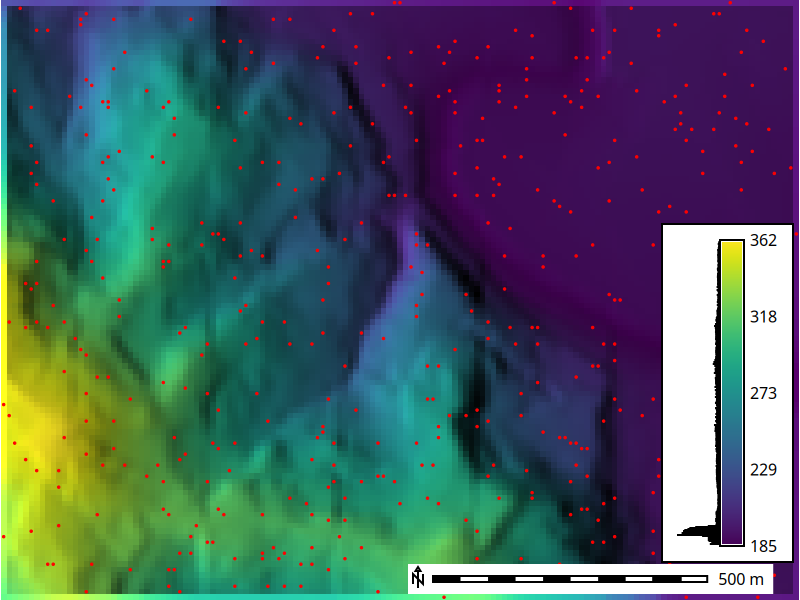

In [8]:
m = gj.Map(use_region=True, height=600, width=800)
m.d_shade(shade="relief", color="dem", brighten=30)
m.d_vect(map="elevrand", color="red", fillcolor="red", icon="basic/point")
m.d_legend(raster="dem", flags="bds", at="9,60,90,93", fontsize=16)
m.d_barscale(at="51,6", fontsize=16, flags="n")
m.show()

<a name="R"></a>

---

## Conditional Gaussian Simulations in R

To do our Conditional Gaussian simulations, we'll move to R. We're going to use the `rgrass` library to read and write data to/from GRASS and we'll use `gstat` to do simulate 100 DEMs.

First, load the rpy2 extension. rpy2 is an interface to R running embedded in a Python process allowing up to continue operating in our current Python session but cells in R. Fancy!

In [9]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Now, we can use the %%R cell magic. When this cell is interpreted, it's contents will be sent to R. We could also use line magic now with %R which would only send the line to R.

In [26]:
%%R
system("apt-get install r-cran-sf r-cran-rgrass r-cran-gstat r-cran-terra r-cran-devtools r-cran-irkernel")

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [33]:
%%R
install.packages("rgrass")

* installing *source* package ‘rgrass’ ...
** this is package ‘rgrass’ version ‘0.5-2’
** package ‘rgrass’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (rgrass)


TypeError: ZMQDisplayPublisher.publish() got an unexpected keyword argument 'source'

We also need some other function to help parameterize our Matern Covariance variogram. Dr. Corey White has drafted a package to help with this. We load it here:

In [14]:
%%R
devtools::load_all("cgsSim/")

ℹ Loading cgsSim


TypeError: ZMQDisplayPublisher.publish() got an unexpected keyword argument 'source'

Load other libraries.

In [16]:
%%R
library(sf)
library(gstat)
library(terra)
library(rgrass)

Use readVECT from rgrass to turn the random elevation points into a [SpatVector](https://rdrr.io/cran/terra/man/SpatVector-class.html), the terra vector class.

In [12]:
%%R
elevrand <- rgrass::read_VECT("elevrand")

Exporting 500 features...
   0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96v.out.ogr complete. 500 features (Point type) written to <elevrand> (GPKG
format).


In [22]:
%R coords

Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  object 'coords' not found


RInterpreterError: Failed to parse and evaluate line 'coords'.
R error message: "Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : \n  object 'coords' not found"

Compute the cutoff and width of the empirical variogram by using the maximum distance between two points. CITATION?

In [23]:
%%R

coords <- terra::geom(elevrand)[, c("x", "y")]
dists <- as.matrix(dist(coords))
max_dist <- max(dists)

# Best practice
# Default cutoff is 0.5 but this is too small for our data
cutoff <- 0.9 * max_dist
width <- cutoff / 15
print(paste("Max Distance:", max_dist))
print(paste("Using cutoff:", cutoff, "and width:", width))

[1] "Max Distance: 1714.78861671053"
[1] "Using cutoff: 1543.30975503947 and width: 102.887317002632"


In [26]:
%R elev_df

Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  object 'elev_df' not found


RInterpreterError: Failed to parse and evaluate line 'elev_df'.
R error message: "Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : \n  object 'elev_df' not found"

With the width and cutoff, we can computate the variogram. First, convert to random sample points to an `sf` dataframe since that is the input format for `gstat`.

In [27]:
!g.region -p

projection: 1 (UTM)
zone:       32
datum:      wgs84
ellipsoid:  wgs84
north:      4779210
south:      4778120
west:       779180
east:       780630
nsres:      10
ewres:      10
rows:       109
cols:       145
cells:      15805


In [28]:
%%R
elev_df <- terra::as.data.frame(elevrand, geom = "XY")
elev_df <- subset(elev_df, select = -c(cat))
head(elev_df)
# saveRDS(elev_df, file = "cgsSim/data/dataframe.rds")
g <- gstat::gstat(formula = log(value) ~ 1, locations = ~x+y, data = elev_df)
# saveRDS(g, file = "cgsSim/data/gstat.rds")

In [29]:
%R g

o{'data': o{'var1': o{'formula': log(value) ~ 1
, 'data':           coordinates    value
1   (779895, 4779205) 195.3707
2   (779905, 4779205) 195.0139
3   (780185, 4779205) 190.2731
4   (780505, 4779205) 195.3991
5   (779215, 4779195) 221.6752
6   (780215, 4779195) 187.6597
7   (780325, 4779195) 195.4028
8   (779335, 4779185) 217.3231
9   (779815, 4779185) 198.2128
10  (779855, 4779185) 196.3891
11  (780475, 4779185) 195.3447
12  (780485, 4779185) 195.2676
13  (779325, 4779175) 218.2330
14  (779385, 4779175) 229.0526
15  (779525, 4779175) 238.6414
16  (779675, 4779175) 204.4849
17  (779705, 4779175) 203.5575
18  (779325, 4779165) 219.0992
19  (780405, 4779165) 195.5669
20  (779245, 4779155) 231.7001
21  (779265, 4779155) 228.3206
22  (779785, 4779155) 199.7972
23  (780115, 4779155) 190.8868
24  (780255, 4779155) 188.5554
25  (780295, 4779155) 195.1206
26  (780375, 4779155) 195.5791
27  (780535, 4779155) 194.8353
28  (780145, 4779145) 190.7128
29  (780375, 4779145) 195.5065
30  (779585,

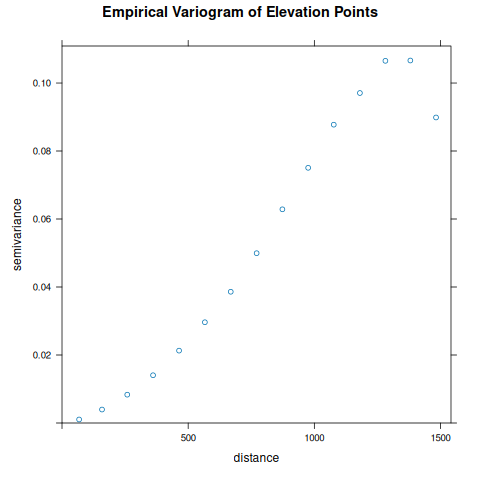

In [30]:
%%R
vg <- gstat::variogram(g, cutoff = cutoff, width = width)
# vg <- gstat::variogram(g, cutoff = 5000, width = 100)
# saveRDS(vg, file = "cgsSim/data/variorgram.rds")

plot(vg, main = "Empirical Variogram of Elevation Points")

Now, we're going to fit a Matern Covariance function to the empirical variogram. First, we'll fit Kappa using `cgSim` library that Dr. Corey White has been working on. We pass the empirical variogram as the input.

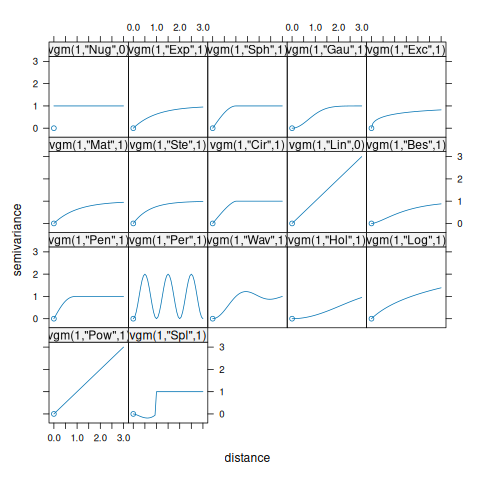

In [ ]:
%%R
library(automap)
sf_elev <- sf::st_as_sf(elevrand)
v_mod_ok = automap::autofitVariogram(value~x+y, sf_elev)

# plot(v_mod_ok)
show.vgms()

In [37]:
%%R
v_mod_ok$var_model

  model        psill   range kappa
1   Nug      5.36681     0.0   0.0
2   Ste 104741.82619 11870.6   0.9


In [38]:
%%R
v_mod_ok

$exp_var
      np      dist       gamma dir.hor dir.ver   id
1     32  10.00000    2.603429       0       0 var1
2    121  19.71895   10.849189       0       0 var1
3    201  32.33611   14.307210       0       0 var1
4    410  47.58666   37.589188       0       0 var1
5    564  66.41159   68.089877       0       0 var1
6    740  85.69758   84.730176       0       0 var1
7   3460 128.31206  184.906540       0       0 var1
8   5036 190.37398  312.823892       0       0 var1
9   9184 269.96172  555.010236       0       0 var1
10 10672 362.55525  879.637101       0       0 var1
11 12071 456.86319 1285.370573       0       0 var1
12 16957 567.09906 1815.933722       0       0 var1

$var_model
  model        psill   range kappa
1   Nug      5.36681     0.0   0.0
2   Ste 104741.82619 11870.6   0.9

$sserr
[1] 112.8601

attr(,"class")
[1] "autofitVariogram" "list"            


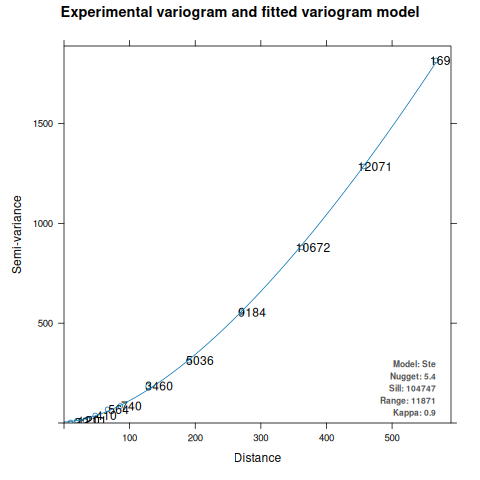

In [39]:
%%R
plot(v_mod_ok)

In [ ]:
%%R
dem = rgrass::read_RAST("dem")

grid_ext <- terra::ext(dem)
grid_res <- 10

xy <- expand.grid(
  x = seq(grid_ext[1], grid_ext[2], by = grid_res),
  y = seq(grid_ext[3], grid_ext[4], by = grid_res)
)
head(xy)
sf_object <- st_as_sf(xy, coords = c("x", "y"), crs = "EPSG:32632")
g = gstat(formula = value~1, model = v_mod_ok$var_model, data = sf_elev)
z_list = predict(g, sf_object, locations = ~x+y, nsim=5)

Checking GDAL data type and nodata value...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Using GDAL data type <Float32>
Exporting raster data to RRASTER format...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
r.out.gdal complete. File </tmp/RtmpTj4psV/file615c47f285e86.grd> created.
drawing 5 GLS realisations of beta...
[using conditional Gaussian simulation]


Exception ignored from cffi callback <function _processevents at 0x787a5f8ee3e0>:
Traceback (most recent call last):
  File "/home/ctwhite/Documents/GitHub/ncsu-geoforall-lab/geomorphometry2025_workshop/.venv/lib/python3.13/site-packages/rpy2/rinterface_lib/callbacks.py", line 283, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt: 


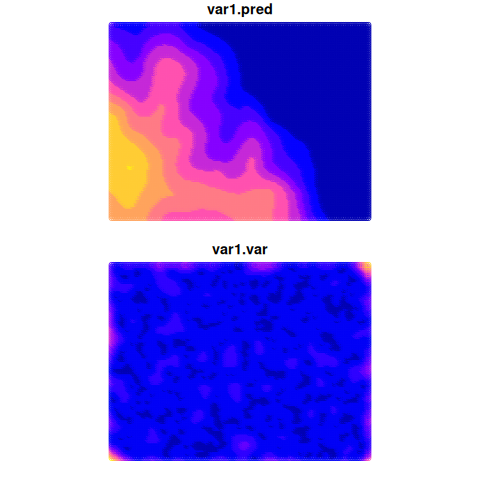

In [42]:
%%R
plot(z)

In [108]:
%%R
# Fit kappa
fit_kappa <- optimize_kappa(vg)
fit_kappa

$model
  model        psill    range    kappa
1   Nug 0.0005494444    0.000 0.000000
2   Mat 0.5600681344 2138.406 1.117054

$kappa
[1] 1.117054

$SSErr
[1] 9.240102e-05



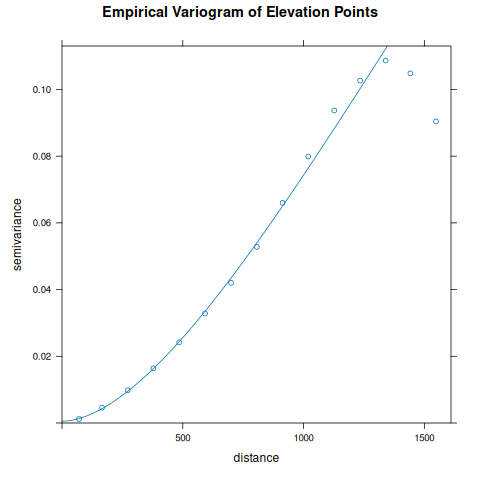

In [109]:
%%R
plot(vg, model = fit_kappa$model, main = "Empirical Variogram of Elevation Points")

In [ ]:
%%R
# Fit variogram automatically: THIS TAKES SO LONG
fit_result <- auto_variogram_fit(elev_df, cutoff = cutoff, width = width, kappa = fit_kappa$kappa)

Let's see some information about our fitted variogram:

In [ ]:
%%R
head(fit_result)

And plot the fitted variogram alonside the empirical variogram.

In [ ]:
%%R
plot_auto_variogram(vg, fit_result$vgm_model)

In [ ]:
# WHAT'S THIS
# vfit <- gstat::fit.variogram(vg, model = fit_result$vgm_model, fit.kappa = FALSE)
vfit <- gstat::fit.variogram(vg, model = vgm_model, fit.kappa = FALSE)

Time to interpolate our DEMs using the fitted variogram. We will only do 10 simulations since the process is computationally intensive but in the GitHub repo, we've included a set of 90 pre-computed simulations that we'll import after this for computed extracted stream uncertainty.

Create a 10m resolution grid for prediction:

In [ ]:
%%R
grid_ext <- terra::ext(elevrand)
grid_res <- 10

xy <- expand.grid(
  x = seq(grid_ext[1], grid_ext[2], by = grid_res),
  y = seq(grid_ext[3], grid_ext[4], by = grid_res)
)

Run 10 stochastic conditional gaussian simulations, creating 10 DEMs. The `run_sim` tool is part of `cgSim` which uses `gstat::predict` on the backend.

In [ ]:
%%R
run_sim(
  elev_df,
  fitmodel = vfit,
  nsim = 100,
  newdata=xy,
  nmin = 10,
  nmax = 40,
  distmax = cutoff,
)

The `run_sim` function writes these rasters into GRASS. Use the GRASS R API to list the simulated rasters:

In [18]:
%%R
rgrass::execGRASS("g.list", type="raster", pattern="sgs_sim_*")

sgs_sim_1
sgs_sim_10
sgs_sim_2
sgs_sim_3
sgs_sim_4
sgs_sim_5
sgs_sim_6
sgs_sim_7
sgs_sim_8
sgs_sim_9


Import the other 90 simulations:

Calculate the mean and standard deviation of the simulatate surfaces

In [19]:
%%R
execGRASS("g.list", type="raster", pattern="sgs_sim_*", output="tmp_list_simulated.txt")
execGRASS("r.series", file="tmp_list_simulated.txt", output="simulated_mean", method="average")
execGRASS("r.series", file="tmp_list_simulated.txt", output="simulated_std", method="stddev")

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


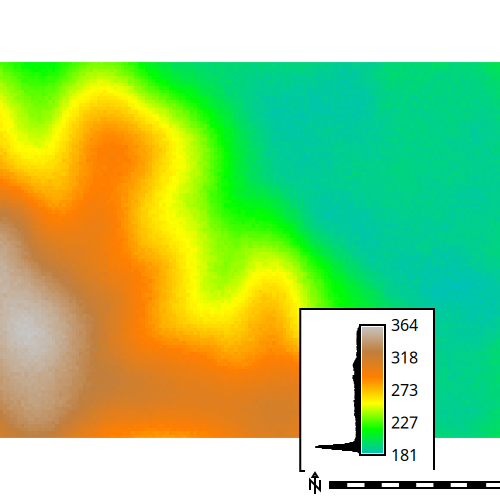

In [41]:
m = gj.Map(use_region=True, height=500, width=500)
gs.run_command("r.colors", map="simulated_mean", color="elevation")
m.d_rast(map="simulated_mean")
m.d_legend(raster="simulated_mean", flags="bds", at="9,35,72,77", fontsize=16)
m.d_barscale(at="61,6", fontsize=16, flags="n")
m.show()

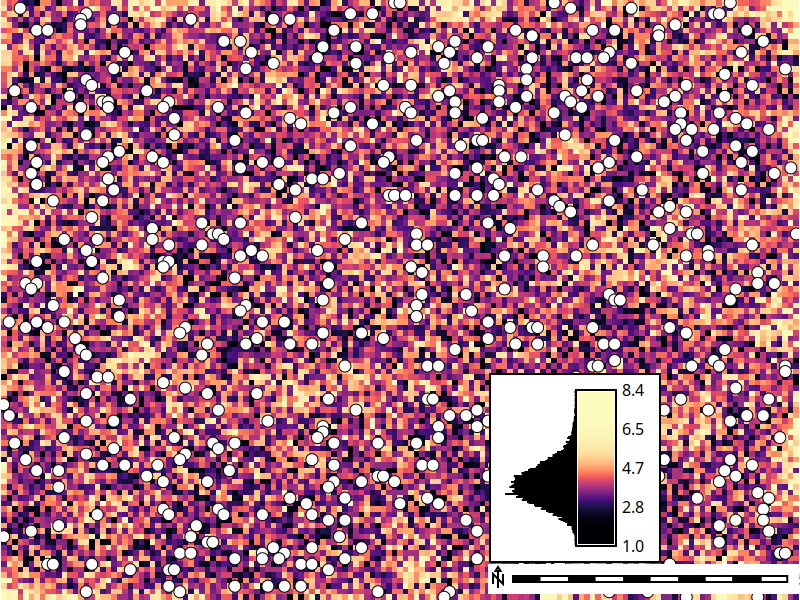

In [35]:
m = gj.Map(use_region=True, height=600, width=800)
gs.run_command("r.colors", map="simulated_std", color="magma", flags="e")

m.d_rast(map="simulated_std")
m.d_vect(map="elevrand", icon="basic/circle", color="black", fill_color="white", size=12)
m.d_legend(raster="simulated_std", flags="bds", at="9,35,72,77", fontsize=16)
m.d_barscale(at="61,6", fontsize=16, flags="n")
m.show()

---

## Extract Streams and Compute Uncertainty

Generate streams for each DEM

In [37]:
%%R
N.sim <- 10
for(i in 1:N.sim) {execGRASS("r.watershed", elevation=paste("sgs_sim_", i, sep=""),
 threshold=500, stream=paste("stream_", i, sep=""), flags=c("quiet"))}

Calculate the probablity and error

INSERT EQUATION AND CITATION

In [ ]:
%%R
execGRASS("g.list", type="raster", pattern="stream*", output="tmp_list_stream.txt")
execGRASS("r.series", file="tmp_list_stream.txt", output="count", method="count")
execGRASS("r.mapcalc", expression=paste("prob = float(count)/", N.sim))
execGRASS("r.mapcalc", expression="error = -prob * log(prob) - (1-prob)* log(1-prob)")

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


Probability that a cell contains a stream:

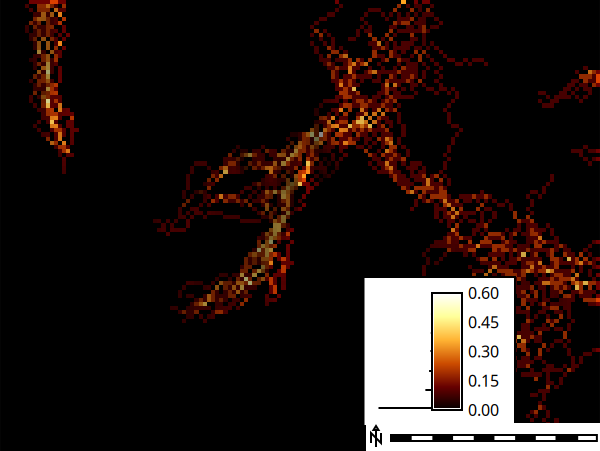

In [65]:
m =gj.Map()
# gs.run_command("g.extension", extension="r.colors.matplotlib")
# gs.run_command("r.colors", map="prob", color="byr")
gs.run_command("r.colors.matplotlib", color="afmhot", map="prob")
m.d_shade(shade="relief", color="prob", brighten=30)
m.d_legend(raster="prob", flags="bds", at="9,35,72,77", fontsize=16)
m.d_barscale(at="61,6", fontsize=16, flags="n")
m.show()

Stream error:

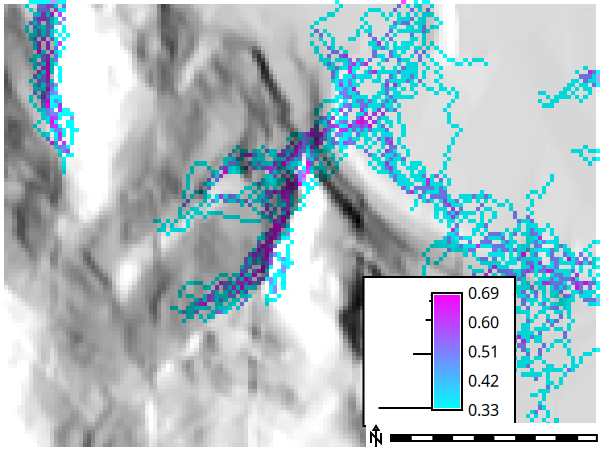

In [70]:
m =gj.Map()
gs.run_command("r.colors.matplotlib", color="cool", map="error")
m.d_shade(shade="relief", color="error", brighten=30)
m.d_legend(raster="error", flags="bds", at="9,35,72,77", fontsize=16)
m.d_barscale(at="61,6", fontsize=16, flags="n")
m.show()


---

## OLD CODE

This works in CoLab but not locally at the moment.

In [ ]:
%%R

# Objective function: SSErr for each kappa
fit_variogram_sserr <- function(kappa) {
  base::attr(gstat::fit.variogram(vg, gstat::vgm(model = "Mat", kappa = kappa)), "SSErr")
}

# Range of kappa values to try
kappa_vals <- base::seq(0.1, 5, by = 0.1)

# # Compute SSErr for each value
sserr_vals <- base::sapply(kappa_vals, fit_variogram_sserr)

# # Optimize for best kappa
opt_result <- optimize(fit_variogram_sserr, c(0.1, 5))

best_kappa <- opt_result$minimum
best_sserr <- opt_result$objective

# # Plot SSErr vs. kappa
# plot(kappa_vals, sserr_vals, type = "b", pch = 16,
#      xlab = expression(kappa), ylab = "Sum of Squared Errors",
#      main = "SSErr vs. Matérn Smoothness (kappa)")

# # Add vertical line at best kappa
# abline(v = best_kappa, col = "grey", lty = 2)

# # Label the optimal point
# text(x = best_kappa, y = best_sserr, labels = paste0("kappa = ", round(best_kappa, 3)),
#      pos = 3, offset = 5, col = "blue")

In [ ]:
%%R

# Create 10m resolution grid for prediction
grid_ext <- terra::ext(elevrand)
grid_res <- 10

xy <- expand.grid(
  x = seq(grid_ext[1], grid_ext[2], by = grid_res),
  y = seq(grid_ext[3], grid_ext[4], by = grid_res)
)

# Convert to sf POINT geometry
xy_sf <- sf::st_as_sf(xy, coords = c("x", "y"))


# Recreate gstat object using sf
g <- gstat::gstat(
  formula = value ~ 1,
  data = elev_df,
  model = vfit,
  locations=~x+y
)


### Saving this for now might use later

In [ ]:
%%R
g <- gstat::gstat(
  formula = value ~ 1,
  data = elev_df,
  model = vfit,
  locations = ~x + y,
  nmin=10,
  nmax=250,
  maxdist=400
)
# Number of SGS realizations
N.sim <- 4

# Output file prefix
output_prefix <- "sgs_sim"

raster_list <- list()

# Run SGS simulations
for (i in 1:N.sim) {
  cat("Simulating realization", i, "...\n")

  # Perform simulation
  sim <- predict(g, newdata = xy_sf, nsim = 1, debug.level = -1)

  # Extract the simulated values
  sim_values <- sim$sim1

  # Add simulated values to the grid
  xy_sf$sim <- sim_values

  # Convert to SpatRaster
  sim_rast <- terra::rast(xy_sf, crs = terra::crs(elevrand))

  # Rename layer
  names(sim_rast) <- paste0("sim_", i)

  # Save to GRASS raster
  out_file <- paste0(output_prefix, "_", i)
  rgrass::write_RAST(sim_rast, out_file)

  # Store in list
  raster_list[[i]] <- sim_rast
}

# Stack all results if needed
r_stack <- terra::rast(raster_list)

# Plot one realization
terra::plot(r_stack[[1]])

In [ ]:
%%R
# Stack all results if needed
r_stack <- terra::rast(raster_list)

# Plot one realization
terra::plot(r_stack)

In [ ]:
%%R

z_sf <- st_as_sf(z, coords = c("x", "y"), crs = crs(elevrand))

plot(z_sf["var1.pred"])

In [ ]:
%%bash

r.colors simulated_mean rast=dem
r.colors sgs_sim_10 rast=dem
r.colors simulated_std co=bcyr -e
r.colors aspect_10 co=aspect
r.slope.aspect simulated_mean slo=slp_mean asp=asp_mean
r.slope.aspect sgs_sim_10 slo=slp_10 asp=asp_10
r.mapcalc "diff_spline_gsim = dem - simulated_mean"
r.colors diff_spline_gsim co=differences

In [ ]:
m = gj.Map(use_region=True, height=600, width=800)
m.d_shade(shade="relief", color="diff_spline_gsim", brighten=30)
m.d_legend(raster="diff_spline_gsim", flags="bds", at="9,35,72,77", fontsize=16)
m.d_barscale(at="61,6", fontsize=16, flags="n")
m.show()

In [ ]:
%%R
sgs_sim_1 <- rgrass::read_RAST("sgs_sim_1")
plot(sgs_sim_1, main = "Simulated Raster 1")

Original Workflow:

https://github.com/ncsu-geoforall-lab/GIS714-assignments/blob/main/Surface_Water_Simulations/WaterSim-Geostatistical-Simulations.ipynb

TUTORIAL Option:

https://geobgu.xyz/r/spatial-interpolation-of-point-data.html